# Clustering

In this workshop, we will be learning about commonly used clustering methods. Clustering is an approach to find structures in data in an unsupervised way, meaning that we do not know the ground truth, and **can not** objectively tell if the algorithm is right or wrong. We can only judge that with our biological knowledge. Clustering is often used before machine learning, to get an insight into the way the data is distributed. 

We will first get some experience with how hierarchical and k-means clustering work on example data. Then, we apply these algorithms on expression data from breast cancer patients, and also briefly learn about PCA and tSNE. 

For each exercise, answers can be viewed by clicking on the questions!

## Table of contents

### 1. Hierarchical clustering
  **1.1 Hierarchical clustering step-by-step:** if you are new to clustering and want to learn the concepts, start here.

**1.2 Dendrograms and linkage methods:** here we play with more technical aspects of hierarchical clustering

### 2. K-means clustering

**2.1 K-means clustering explained:** a short introduction to k-means clustering. 

**2.2 K-means clustering applied:** we use k-means clustering on a few small datasets. 

### 3. Cluster validation

**3. Davies-Bouldin index:** a way to 'objectively' validate clustering results

### 4. Applications on real biological data

**4.1 Hierarchical clustering on a breast cancer dataset:** If you already know about clustering and just want to apply it to real data, start here!

**4.2 PCA and tSNE on a breast cancer dataset**

### 5. Advanced exercises

If you want another challenge, here you can play with additional clustering methods on the biological data, or try to optimize what you have already done in the exercises.  

<br />
<br />

All the data required for a specific section will be loaded at the beginning of each chapter, so make sure to always run those cells first!

These are all the libraries we will use in this notebook:

In [11]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
import sklearn
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fclusterdata
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans
from pylab import axes
from scipy.spatial.distance import pdist, squareform
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn import manifold

!git clone https://github.com/UMCUGenetics/ONCODE_MC.git

sys.path.append('/content/ONCODE_MC/clustering')

from dbIndex import computeDBIndex

import warnings
warnings.filterwarnings("ignore")

Let's learn how clustering works with a step-by-step example of **hierarchical clustering**. 

### 1.1 Hierarchical clustering step-by-step

We are given this toy dataset:

<table style="width:50%">
  <tr>
    <th>Object</th>
    <th>Feature 1</th>
    <th>Feature 2</th>
  </tr>
  <tr>
    <td>A</td>
    <td>1</td>
    <td>2</td>
  </tr>
  <tr>
    <td>B</td>
    <td>2.5</td>
    <td>4.5</td>
  </tr>
  <tr>
    <td>C</td>
    <td>2</td>
    <td>2</td>
  </tr>
  <tr>
    <td>D</td>
    <td>4</td>
    <td>1.5</td>
  </tr>
  <tr>
    <td>E</td>
    <td>4</td>
    <td>2.5</td>
  </tr>
</table> 
<br />



Let's create the data in Python and visualize it in a scatterplot:

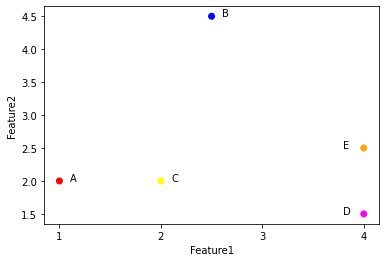

In [ ]:
data = np.array([[1,2.5,2,4,4],[2,4.5,2,1.5,2.5]]).T #generate the toy data
plt.figure()
plt.scatter(data[:,0], data[:,1], c=['red', 'blue', 'yellow', 'magenta', 'orange']) #plot the data

plt.xticks([1,2,3,4]) #set the x axis ticks to format the plot nicely

#Add names of the objects to the plot
plt.text (1.1,2, 'A' )
plt.text (2.6,4.5, 'B' )
plt.text (2.1,2, 'C' )
plt.text (3.8,1.5, 'D' )
plt.text (3.8,2.5, 'E' )
plt.xlabel("Feature1")
plt.ylabel("Feature2")

plt.show() #show the plot on screen

Initially, every point is its **own cluster**. We then start merging clusters based on their **distance**. A commonly used distance metric is the smallest Euclidean distance. This results in a cluster between points A and C (or D and E first is also possible):  


<img src="https://github.com/mnieboer/notebookTesting/blob/main/Figures/clustering_step1.png?raw=1" alt='clustering_step1' width='400' />

We then re-compute the Euclidean distance between **all** clusters. Because A and C are now in one cluster, we can compute the distance from this cluster to the other clusters by taking the point within this cluster that is closest to the other clusters, for example. In this dataset, that would be point **C**. In the second step, D and E will be merged. Then A+C and D+E, and finally, the furthest away point B is added: 

<img src="https://github.com/mnieboer/notebookTesting/blob/main/Figures/clustering_steps2-4.png?raw=1" alt="clustering_steps2-4" />

Rather than using just the **smallest distance**, there are multiple ways to merge clusters together, which are called **linkage methods**, which we will explore next. We also look at **dendrograms**, a way of visualizing the clustering process. 

### 1.2 Linkage methods and dendrograms 

#### 1.2.1 Single linkage

With single linkage, the distance between two clusters is defined as the distance between two closest members of those clusters, as we saw in the example. 

Single linkage is ideal for finding elongated clusters, or identifiying outliers. 

This is the code that you would use to perform single-linkage clustering: 

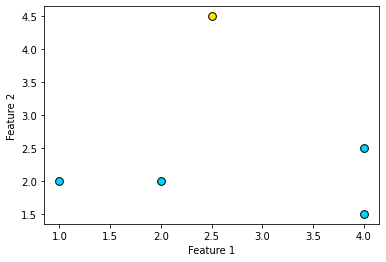

In [ ]:
def plotCluster(data, numClusters, distanceMetric, linkageMethod, xlabel='Feature 1', ylabel='Feature 2'):
    #maxclust indicates that we want a maximum clusters of the number provided in the numClusters variable. 
    label = fclusterdata(data, numClusters, criterion='maxclust', metric=distanceMetric, method=linkageMethod) 

    fig = plt.figure()
    ax = axes()
    num = data.shape[1]
    for l in np.unique(label):
        ax.scatter(data[label == l,0], data[label == l,1],
                   color=plt.cm.jet(float(l) / np.max(label + 1)), #select the colors from the colormap
                   s=60, edgecolor='k')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

data = np.array([[1,2.5,2,4,4],[2,4.5,2,1.5,2.5]]).T #Our toy dataset
plotCluster(data, 2, 'euclidean', 'single') #plot the clustering results in a scatter plot

**Dendrograms** are useful to visualize the clustering process. From a dendrogram, we can tell which data points are merged at which step, and what the distance between them was at this stage. However, it shows **all** possible ways of clustering the data, and does not show 1 final clustering. This is something the user needs to decide. For example, if you are working with tumor/normal data and are expecting 2 clusters, you would look at the result when there are 2 clusters. 

Using this code, we build a dendrogram for this dataset, using Euclidean distance and single linkage:

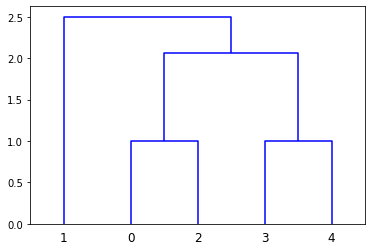

In [ ]:
data = np.array([[1,2.5,2,4,4],[2,4.5,2,1.5,2.5]]).T #Our toy dataset


Z = linkage(data, 'single') #Compute the distance using single-linkage

plt.figure()
dendrogram(Z, color_threshold=1) #plot the dendrogram
plt.show()

<details>
    <summary>&#10551; <b>Exercise 1.</b> Can you link the branches of the dendrogram to the points in the clustering plot?</summary> 
    Answer: 0 and 2 - (1,2) and (2,2) OR (4,1.5) and (4,2.5) <br />
    3 and 4 - (4,1.5) and (4,2.5) OR (1,2) and (2,2) <br />
    1 – (2.5,4.5)
</details>


#### 1.2.2 Complete linkage

Complete linkage defines the distance between two groups as the distance between their two farthest-apart members. This method usually finds clusters that are well separated and compact.

We again make the dendrogram:

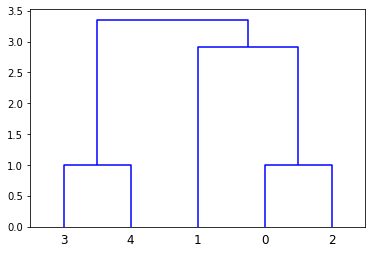

In [ ]:
data = np.array([[1,2.5,2,4,4],[2,4.5,2,1.5,2.5]]).T #Our toy dataset
Z = linkage(data, 'complete') #Compute the distance using complete-linkage
plt.figure()
dendrogram(Z, color_threshold=1) #plot the dendrogram
plt.show()

#### 1.2.3 Average linkage

Average linkage defines the distance between groups as the average distance between each of the members, weighted so that the two groups have an equal influence on the final result:

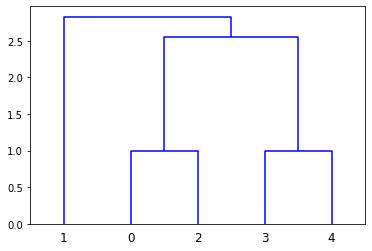

In [ ]:
data = np.array([[1,2.5,2,4,4],[2,4.5,2,1.5,2.5]]).T #Our toy dataset
Z = linkage(data, 'average') #Compute the distance using average-linkage
plt.figure()
dendrogram(Z, color_threshold=1) #plot the dendrogram
plt.show()

<details>
    <summary>&#10551; <b>Exercise 2.</b> Reconstruct the distances between the clusters from the dendrograms.</summary>
    Answer: <br/>
    Single linkage: <br />
    0 to 2 and 3 to 4: distance of 1 <br />
    0 and 2 to 3 and 4: distance of 2 <br />
    0 and 2 and 3 and 4 to 1: distance of around 2.5 <br />
    Complete linkage: <br />
    0 to 2 and 3 to 4: distance of 1 <br />
    0 and 2 to 1: distance of 3 <br />
    3 and 4 to 1: distance of around 3.3 <br />
    Average linkage: <br />
    0 to 2 and 3 to 4: distance of 1 <br />
    0 and 2 to 3 and 4: distance of 2.5 <br />
    0 and 2 and 3 and 4 to 1: distance of around 2.8 <br />

### 1.3 Cutting the dendrogram

To get the result for our desired number of clusters, we can 'cut' the dendrogram horizontally. The number of vertical 'stems' that you see at that level, corresponds to the number of clusters you will get. 

The code below cuts the average linkage dendrogram of 1.2.3 at a height of 1.5:

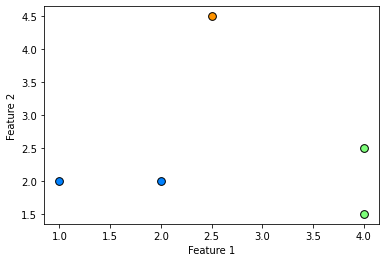

In [ ]:
#We can use the distance criterion to cut the dendrogram at the right height.
#The threshold parameter corresponds to the height at which we cut the dengrogram
def cutDendrogram(data, threshold, distanceMetric, linkageMethod, xlabel='Feature 1', ylabel='Feature 2'):
    label = fclusterdata(data, threshold, criterion='distance', metric=distanceMetric, method=linkageMethod)

    fig = plt.figure()
    ax = axes()
    num = data.shape[1]
    for l in np.unique(label):
        ax.scatter(data[label == l,0], data[label == l,1],
                   color=plt.cm.jet(float(l) / np.max(label + 1)),
                   s=60, edgecolor='k')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

data = np.array([[1,2.5,2,4,4],[2,4.5,2,1.5,2.5]]).T #Our toy dataset


cutDendrogram(data, 1.5, 'euclidean', 'average')
#Change value 1.5 to any height at which you wish to cut the dendrogram, form your answer from looking at the dendrogram above. Then check with the result.

#Change 'average' to another linkage method to see the result.


<details>
    <summary>&#10551; <b>Exercise 4.</b> How many clusters are formed at the current cutting height? </summary>
    Answer: 3 clusters. 
</details>
<br />
<details>
    <summary><b>Exercise 5. </b>In the code, change the height at which the tree is cut. Also try different linkage methods and see how it affects the clustering. </summary>
</details>


### 1.4 Clustering the messy dataset

The messy dataset is a dataset meant to represent gene expression data. It contains 300 points in a 2D space (e.g. the measurements of 300 genes using 2 microarrays, as one would observe with for example a case-control study). 

First, load the messy dataset and visualize it. The plot shows the 300 genes as dots. The X-axis indicates the measurement values of the first microarray (Measurement 1), while the measurement values of the second microarray are shown on the Y-axis (Measurement 2):

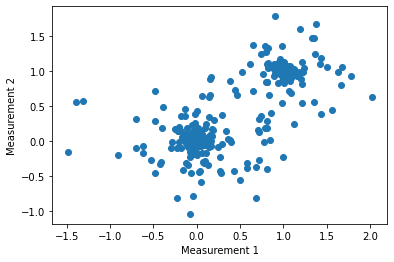

In [13]:
messy = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/messy.txt") #load the messy dataset

#Visualize the messy dataset
plt.scatter(messy[:,0], messy[:,1])
plt.xlabel('Measurement 1')
plt.ylabel('Measurement 2')
plt.show()

<details>
    <summary>&#10551; <b>Exercise 6.</b> What is the optimal number of clusters for this dataset? </summary>
    Answer: There is no good answer to this question as it depends on the question that you are trying to answer, but visually you may conclude that 2 clusters are optimal.
</details>
<br />
<details>
    <summary>&#10551; <b>Exercise 7.</b> Run the code snippet below to form 2 clusters with the different linkage methods. Which method works best?  </summary>
    Answer: complete linkage.
</details>
<br />
<details>
    <summary>&#10551; <b>Exercise 8.</b> Can you explain why some linkages do not work for this data? </summary>
    Answer: In datasets with a lot of noise, single linkage will easily connect the clusters, since the borders of the clusters are closely together and thus have a small distance between them. Average linkage is affected by the same problem, as the average distance between many points is still very small, and thus due to the noise the clusters easily get connected. As complete linkage utilizes the largest distance between points in two clusters, it overcomes
the noise at the cluster boundaries and still finds two clusters. Complete linkage is often a better option for clusters that overlap due to noise, while single linkage is better at identifying outliers.
</details>

Single linkage: 


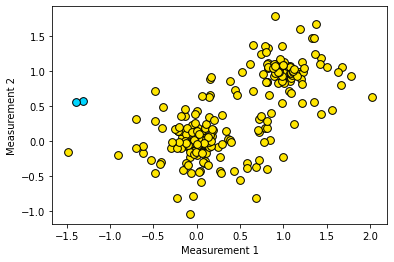

Complete linkage: 


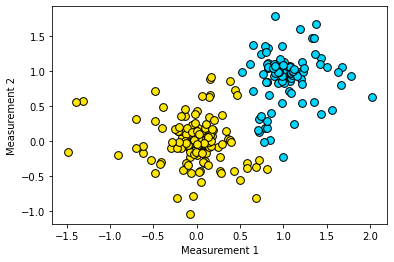

Average linkage: 


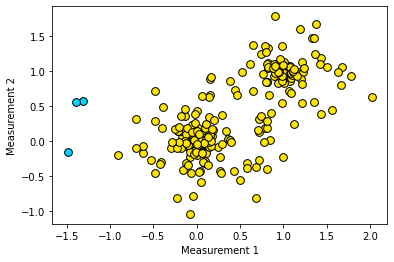

In [ ]:
messy = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/messy.txt")
print("Single linkage: ")
plotCluster(messy, 2, 'euclidean', 'single', xlabel='Measurement 1', ylabel='Measurement 2')
print("Complete linkage: ")
plotCluster(messy, 2, 'euclidean', 'complete', xlabel='Measurement 1', ylabel='Measurement 2')
print("Average linkage: ")
plotCluster(messy, 2, 'euclidean', 'average', xlabel='Measurement 1', ylabel='Measurement 2')

### 1.5 Clustering the cigars dataset

Next, we load and visualize the cigars dataset:

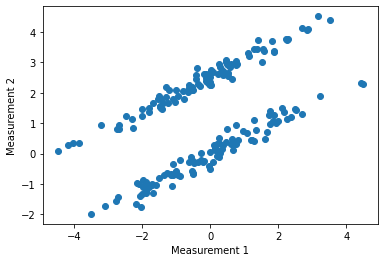

In [ ]:
cigars = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/cigars.txt") #load the cigars dataset

#Visualize the cigars dataset
plt.scatter(cigars[:,0], cigars[:,1])
plt.xlabel('Measurement 1')
plt.ylabel('Measurement 2')
plt.show()

<details>
    <summary>&#10551; <b>Exercise 9.</b> Which linkage method do you think will work best with the cigars dataset? </summary>
    Answer: Single linkage works well with ‘string’-shaped clusters that are well-separated from each other. Therefore, it is the most suitable option for this dataset.
</details>
<br />
<details>
    <summary>&#10551; <b>Exercise 10.</b> Run the code below to try the different linkage methods. Did you expect this clustering? Can you explain this behaviour? </summary>
    Answer: Because the clusters are very long, complete linkage fails because it attempts to find the shortest distance between the two points that are furthest away in the clusters. If we take the two furthest away points between the ends of the cigars and between the two cigars, the distance between the two points will always be smaller within the cigars than between the cigars. Therefore, complete linkage prefers to divide the cigars into two. The same issue occurs with average linkage, where the average distance within cigars is larger than the average distance between cigars.
</details>

Single linkage: 


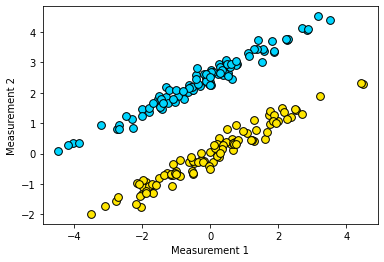

Complete linkage: 


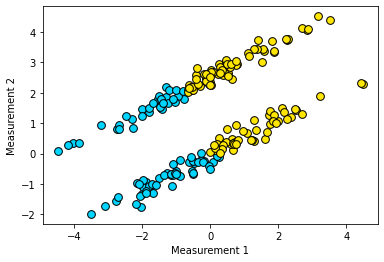

Average linkage: 


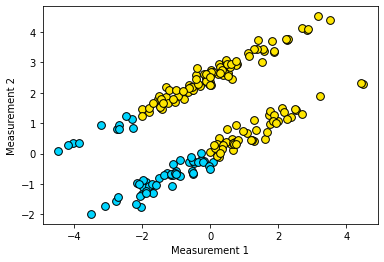

In [ ]:
cigars = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/cigars.txt")
print("Single linkage: ")
plotCluster(cigars, 2, 'euclidean', 'single', xlabel='Measurement 1', ylabel='Measurement 2')
print("Complete linkage: ")
plotCluster(cigars, 2, 'euclidean', 'complete', xlabel='Measurement 1', ylabel='Measurement 2')
print("Average linkage: ")
plotCluster(cigars, 2, 'euclidean', 'average', xlabel='Measurement 1', ylabel='Measurement 2')

### 1.6 Pearson and Mixed correlation

For this exercise, we use a dataset containing 10 measurements on 5 genes, on which we will explore the effects of using correlation and mixed correlation (signed).  

We can visualize the measurements in a line plot. Each line represents one gene. The X-axis shows the measurement number, while the Y-axis shows the measurement value: 

In [1]:
#load the distance.txt dataset
distanceData = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/distance.txt")

xValues = range(0,distanceData.shape[1]) #each measurement is a point in the data

plt.figure()
for geneInd in range(0, distanceData.shape[0]):
    yValues = distanceData[geneInd,:]
    plt.plot(xValues, yValues, label=f"gene {geneInd}")

#Add a legend here as well to correspond with dendrogram labels
plt.xlim(-1,11) #move the axis a bit to show the legend
plt.legend()
plt.xlabel("Measurement")
plt.ylabel("Gene expression level")
plt.show()

NameError: name 'np' is not defined

<details>
    <summary>&#10551; <b>Exercise 11.</b> How will the genes be clustered when using the Euclidean distance and complete linkage? What does it mean when genes are in the same cluster? </summary>
    Answer: Assuming 3 clusters, gene 0 and 2 are a cluster, gene 3 and 4 are a cluster, and gene 1 is a cluster. 
Genes cluster based on their Euclidean distance, and thus will cluster together when these have similar patterns in gene expression over time.
</details>


Check your answer using the code below: 

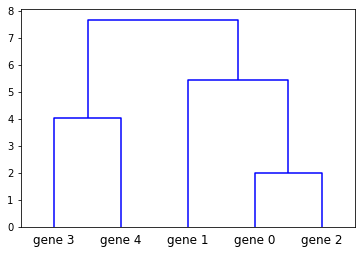

In [ ]:
distanceData = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/distance.txt")
Z = linkage(distanceData, 'complete') #Compute the distance using complete-linkage, uses euclidean distance by default
plt.figure()
dendrogram(Z, color_threshold=1, labels = ["gene 0","gene 1","gene 2","gene 3","gene 4"]) #plot the dendrogram
plt.show()

Now we will switch to using correlation as a similarity measure. 

<details>
    <summary>&#10551; <b>Exercise 12.</b> Run the code below to cluster using correlation. How are the genes clustered now?  </summary>
    Answer: if one gene goes up and another does too around the same time, these are more likely to cluster together. So the 'direction' of effect becomes more important than their overall distance. 
</details>



In [ ]:
#Now use correlation-based distances

Z = linkage(distanceData, metric='correlation', method='complete') #Compute the distance using complete-linkage, uses euclidean distance by default
plt.figure()
dendrogram(Z, color_threshold=0, labels = ["gene 0","gene 1","gene 2","gene 3","gene 4"]) #plot the dendrogram
plt.show()

Finally, we can run the code below to use the mixed-correlation measure. 

<br />

<details>
    <summary>&#10551; <b>Exercise 13.</b> Is the clustering different from the previous, correlation-based result? How can you explain this result? </summary>
    Answer: Using mixed correlation, the increasing/decreasing pattern is no longer observed, and thus the distance and correlation between all lines becomes smaller.
</details>


In [ ]:
#Function to compute the mixed correlation between two points
def computeMixedCorrelation(dataX, dataY):

    mixedCorrelation = 1 - np.abs(np.corrcoef(dataX,dataY))[1][0]
    return mixedCorrelation

#Make the dendrogram using mixed correlation
Z = linkage(distanceData, metric=computeMixedCorrelation, method='complete') #Compute the distance using complete-linkage, uses euclidean distance by default
plt.figure()
dendrogram(Z, color_threshold=0, labels = ["gene 0","gene 1","gene 2","gene 3","gene 4"]) #plot the dendrogram
plt.show()


# 2. K-means clustering

K-means clustering is another method that partitions the data in to **k** clusters (k to be defined by the user). It starts by putting **k** points at random positions in the data space, called **centroids**. Each data point is assigned to the nearest centroid, together forming a cluster. The centroid is then updated to the mean of the data points that were assigned to it. This process is repeated iteratively, until convergence. 

The k-means method is not guaranteed to converge to the global optimum and often terminates at a local optimum. The results may depend on the initial random selection of cluster centres. To obtain good results in practice, it is common to run the k-means algorithm multiple times with different initial cluster centres.

A big difference with hierarchical clustering is that k-means updates the clustering continuously. The hierarchical clustering method starts from the bottom, and combines observations to clusters. At higher levels it can only fuse existing clusters to others, but it cannot break old groups to build better ones, which k-means clustering can. Thus, it may end up finding clusterings that are not possible with hierarchical clustering. 


The following function performs k-means clustering:

In [ ]:
def kmeans(data, numClusters, initPoints = 'random'):

    kmeans = KMeans(n_clusters=numClusters, init=initPoints)
    kmeans.fit(data)
    y_kmeans = kmeans.predict(data)

    plt.scatter(data[:, 0], data[:, 1], c=y_kmeans, s=40, cmap='plasma', alpha=0.5)

    #Also plot the cluster centers
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=80, marker = "x")
    plt.show()


We will try k-means clustering on another *messy* dataset. The cross represents the center of the cluster:

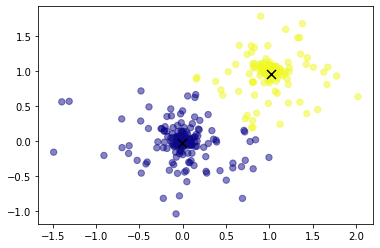

In [ ]:
#load the messy dataset
messy = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/messy.txt")

#the numberOfClusters parameter can be changed to get different clusters
numberOfClusters = 2
kmeans(messy, numberOfClusters)

<details>
    <summary>&#10551; <b>Exercise 14.</b> Change the number of clusters in the code above by trying different values for the <i>numberOfClusters</i> variable in the code snippet above. What is the result on the clustering? </summary>
    Answer: depending on how many clusters are set, k-means will continue searching for an optimal clustering, which can be better or worse, depending on your biological question.
</details>


Next, load the cigars dataset and perform k-means clustering with 2 clusters:

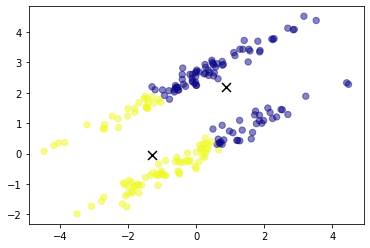

In [ ]:
#Load the cigars dataset
cigars = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/cigars.txt")

numberOfClusters = 2
kmeans(cigars, numberOfClusters)


<details>
    <summary>&#10551; <b>Exercise 15.</b> Compare the result of k-means clustering with the hierarchical clustering. Can you explain the differences?</summary>
    Answer: With k-means, we use random initialization points. In hierarchical clustering, we always start clustering from the points with the smallest distance and end up with the same clustering. Therefore, k-means has a greater capability to explore different ways of clustering the data and find an optimal solution, whereas with hierarchical clustering the user has to determine this by choosing the correct linkage method.
</details>
<br />

<details>
    <summary>&#10551; <b>Exercise 16.</b> How can we overcome the problem that k-means can converge to local minima?</summary>
    Answer: By running k-means multiple times with different initialization point, different ways of clustering the data can be explored, and the overall best solution can be selected from different rounds.
</details>


# 3. Cluster validation: Davies-Bouldin index

The Davies-Bouldin criterion is a metric that aims to minimize the ratio of within-cluster and between-cluster distances. By testing a range of values for the number of clusters (k), we can try to find an optimal number of clusters for the data at hand based on the minimum Davies-Bouldin index. 

Using the following code, we can compute the Davies-Bouldin indices for a different number of clusters on the messy dataset (this may take a little while, so please be patient):

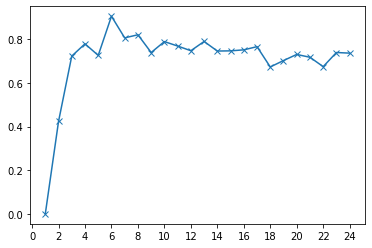

In [ ]:
#loop across different numbers of clusters, run kmeans and then obtain the db index. 
#Make a plot of the results

#Load the data
messy = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/messy.txt")
data = messy

clusterNums = range(1,25) #define how many clusters we want to check

dbIndices = []
for clusterNum in clusterNums:
    
    #perform kmeans
    kmeans = KMeans(n_clusters=clusterNum) 
    kmeans.fit(data)
    y_kmeans = kmeans.predict(data)

    #Also plot the cluster centers
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    #Compute the DB-index
    dbIndex = computeDBIndex(data, centers, labels)
    dbIndices.append(dbIndex)

#Visualize the DB index as a function of the number of clusters
plt.figure()
plt.plot(clusterNums, dbIndices, marker='x')
plt.xticks(range(0,len(clusterNums)+2,2)) #show the x ticks increasing by 2 for clarity
plt.show()

<details>
    <summary>&#10551; <b>Exercise 17.</b> What is the optimal number of clusters? Does this match your expectations based on the scatterplot and previous clustering results?</summary>
    Answer: the optimal number is 2. The score is theoretically lower at a cluster size of 1, but since our goal is to cluster, we only consider answers > 1.
</details>
<br />
We can do the same with different clustering methods, such as hierarchical clustering. 

<br />
<br />

<details>
    <summary>&#10551; <b>Exercise 18.</b> Run the code below with different linkage methods (change the *linkageMethod* parameter). Does it change the optimal number of clusters?</summary>
    Answer: Yes, the optimal number changes depending on the linkage that is used. What the actual best number of clusters is, depends on your research question.
</details>


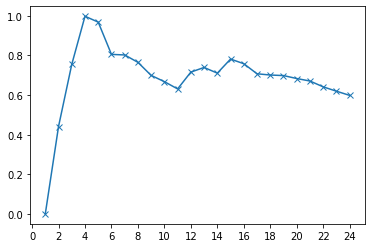

In [ ]:
linkageMethod = 'complete' #Change this to either single, average or complete
distanceMetric = 'euclidean'

messy = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/messy.txt")
data = messy

clusterNums = range(1,25)

dbIndices = []
for clusterNum in clusterNums:
    
    #perform hierarchical clustering
    labels = fclusterdata(data, clusterNum, criterion='maxclust', metric=distanceMetric, method=linkageMethod) 
    labels -= 1 #make this 0-based
    #Compute the cluster centers
    centers = []
    for clusterInd in np.unique(labels):
        #obtain points from this cluster
        pointIndices = np.argwhere(labels == clusterInd)
        pointIndices = np.concatenate( pointIndices, axis=0 )

        clusterPoints = data[pointIndices,:]
        #compute the mean X and mean Y
        center = np.mean(clusterPoints, axis=0)
        centers.append(center) 
    
    centers = np.array(centers)
    
    dbIndex = computeDBIndex(data, centers, labels)
    dbIndices.append(dbIndex)

plt.figure()
plt.plot(clusterNums, dbIndices, marker='x')
plt.xticks(range(0,len(clusterNums)+2,2)) #show the x ticks increasing by 2 for clarity
plt.show()

# 4. Clustering real breast cancer data

In the following exercises, we will be using a subset of genes of the *van 't Veer* dataset (Laura J. van't Veer et al., "Gene 
expression profiling predicts clinical outcome of breast cancer", Nature, 2002, 415:530-536). This dataset consists of gene expression profiles of 78 patients with either a good outcome (disease free for at least 5 years) or a poor outcome (a metastasis  was found within 5 years). The aim of the original study was to predict breast cancer outcome from gene expression data. 

In these exercises, we will be applying the clustering techniques that we learned to obtain more insight into how gene expression can affect disease outcome. 

First, we load the dataset:

In [ ]:
#Load the van 't Veer dataset
vantVeer = np.loadtxt("/content/ONCODE_MC/clustering/Datasets/vantVeerAnnotated.txt", dtype='object')

#Extract the labels, data and other information from the full dataset
labels = vantVeer[0,1:vantVeer.shape[1]].astype(int) #we skip the first column, which contains row names
geneNames = vantVeer[3:vantVeer.shape[0],0] #These are the names of the genes
vantVeerData = vantVeer[3:vantVeer.shape[0], 1:vantVeer.shape[1]].astype(float) #The actual data values


The dataset contains the expression of multiple genes of 78 patients, which is difficult to visualize in 2D. Thus, we can select 2 genes for which we plot the expression:

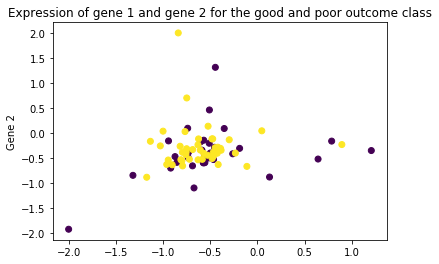

In [ ]:
#data[0,:] means the first gene, data[1,:] is the second. Change these numbers to see expression of different genes. 
plt.scatter(vantVeerData[0,:], vantVeerData[1,:], c=labels)
plt.xlabel('Gene 1')
plt.ylabel('Gene 2')
plt.title('Expression of gene 1 and gene 2 for the good and poor outcome class')
plt.show()


<details>
    <summary>&#10551; <b>Exercise 19.</b> Try to select different genes to put on the axes in the code snippet above. Is there a combination of genes for which clusters become visible?</summary>
    Answer: because the data is in a high-dimensional space, with many (noisy) features, it is usually impossible to see a clustering in 2D, even when it does exist in high-dimensions. 
</details>

### 4.1 Using hierarchical clustering on the breast cancer data


Because it is difficult to visualize the clustering of more than 2 dimensions in a scatterplot, we can use a heatmap in which we show the clustering of the patients and genes on the axes. Because there are too many genes to show in the heatmap, we will randomly subset to 100 genes for this example. 

In [ ]:
#subset the data for the heatmap
randomGeneInd = np.random.choice(range(0,vantVeerData.shape[0]), 100)

vantVeerDataSubset = vantVeerData[randomGeneInd, :]

#get names of random genes
geneNamesSubset = geneNames[randomGeneInd]


Next, we plot the heatmap: 

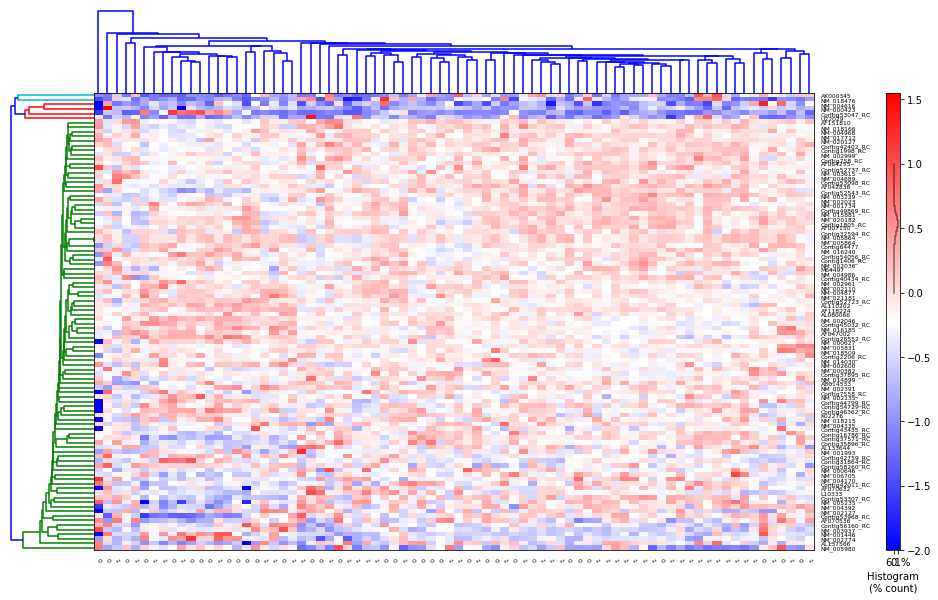

In [ ]:
import heatmap as hm

h = hm.heatmapcluster(vantVeerDataSubset, geneNamesSubset, labels,
                   num_row_clusters=3, num_col_clusters=0,
                   label_fontsize=6,
                   xlabel_rotation=-75,
                   cmap=plt.cm.bwr,
                   colorbar_pad=1,
                   show_colorbar=True,
                   top_dendrogram=True,
                   row_linkage=lambda x: linkage(x, method='average', #linkage method for the rows
                                                 metric='seuclidean'),  #distance metric for the rows
                   col_linkage=lambda x: linkage(x.T, method='average', #linkage method for the columns
                                                 metric='seuclidean'), #distance metric for the columns
                   histogram=True)

plt.show()

<details>
    <summary>&#10551; <b>Exercise 20.</b> Can you identify meaningful clusters of genes in the heatmap? What does a cluster here represent? And what about the patients? </summary>
    Answer: the rows are clusters of genes, the columns are clusters of patients. 
</details>
<br />
<details>
    <summary><b>Exercise 21.</b> Choose a cluster of genes that you think is interesting for predicting disease outcome. Upload these gene names to Uniprot (http://www.uniprot.org/uniprot/). For which GO terms is the cluster enriched? Are the results reported on this page relevant to the disease?</summary>
</details>
<br />
<details>
    <summary>&#10551; <b>Exercise 22.</b> Try different values for the clustering linkage and distance method in the heatmap code above (the values of row_linkage and col_linkage are what you should be looking for). Does it affect the clustering? How can you determine which linkage and distance metric are optimal for this dataset?  </summary>
    Answer: to get an objective answer, the DB-index could work. However, here again, whether the results are optimal depends on your biological question. You could say that if your patients are divided into 2 groups by their labels, and clusters of genes are identified that clearly show differences between these patient groups, that the clustering is useful. 
</details>


### 4.2 Dimension reduction: using PCA and tSNE on the breast cancer data

As visualizing clustering results in more than 2 dimensions is difficult, many people use PCA or tSNE to find structure in the data as an alternative to clustering. PCA and tSNE are **dimension reduction** techniques, meaning that they take high-dimensional data, and project it to a lower number of dimensions, such as 2. 

The idea behind dimension reduction techniques, is that not all dimensions, for example our genes, are important to distuingish our patient classes. Some may just add noise, and there is no need to be looking at them. In **PCA**, linear combinations are made between all dimensions, such as adding and subtracting. It will look for combinations that show the most variation between our classes, which makes it more likely that we can separate them. These combinations are called **principal components (PCs)**. The PCs are sorted in the output, meaning that the first PC is best for separating the classes. 

On the other hand, **tSNE** looks for non-linear combinations rather than linear. If non-linear relations exist between the features, tSNE will yield better output than PCA. However, this is often not known beforehand, when working with high-dimensional biological data. 

#### 4.2.1 PCA

We start with applying PCA to our breast cancer dataset, reducing to 2 dimensions only:

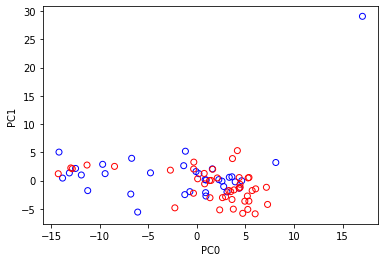

In [ ]:
pca = PCA(n_components=2) #reduce to 2 dimensions so that we can visualize easily

projected = pca.fit_transform(vantVeerData.T)
colorLabels = []
for label in labels:
    if label == 0:
        colorLabels.append('b')
    elif label == 1:
        colorLabels.append('r')
        
#change 0 and 1 below here to visualize different principal components. 
plt.scatter(projected[:, 0], projected[:, 1], edgecolors=colorLabels, facecolors='none')
plt.ylabel('PC1')
plt.xlabel('PC0')
plt.show()


<details>
    <summary>&#10551; <b>Exercise 23.</b> Do we identify clusters in the PCA plot? Why or why not? Do other principal components reveal better clustering? </summary>
    Answer: there is some sort of clustering visible, but it also shows that there is either noise in the labels or the features that makes it difficult to find a perfect separation of the groups. 
</details>

#### 4.2.2 tSNE

With tSNE, there are a number of things to keep in mind: 

First is that we can set **parameters** that affect the result. The most important one is **perplexity**. In simple terms, it makes an estimate of how many close neighbors each point has in our high-dimensional space. Typical perplexity values range between 5-30. The value should always be smaller than the number of data points. 

Second, because tSNE maps the data to a different space, we cannot interpret distances between data points in the tSNE output. Thus, points that are close together, may not actually be close in the high-dimensional space. Similarly, we cannot say if clusters are far away from each other or not.  

Here is a good source explaining common pitfalls when using tSNE: https://distill.pub/2016/misread-tsne/

The following code snippet runs tSNE on the breast cancer dataset:

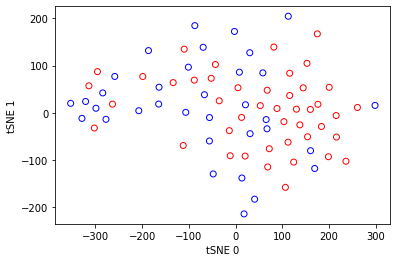

In [ ]:
tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=20)
Y = tsne.fit_transform(vantVeerData.T)
plt.scatter(Y[:, 0], Y[:, 1], edgecolors=colorLabels, facecolors='none')
plt.ylabel('tSNE 1')
plt.xlabel('tSNE 0')
plt.show()


<details>
    <summary>&#10551; <b>Exercise 24.</b> Do we identify clusters in the tSNE plot? Why or why not?  </summary>
    Answer: it is difficult to see. It could be due to label noise, noisy features, but also due to settings that are not optimal.  
</details>
<br />
<details>
    <summary><b>Exercise 25.</b> Try using different perplexity values for tSNE and see how it changes the results. </summary>
 
</details>


# 5. Advanced section

If you have time left and want to explore more on the previous exercises, you can for example try:

- Trying different linkage and distance metrics to make the heatmap
- Using k-means clustering on the real biological data

If you instead want to try a completely different algorithm, you can for example implement other clustering methods. A lot can be found in *sklearn.cluster* (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster), so feel free to for example try DBScan or Mean Shift clustering. 
